# ABOUT


Datascientest's Datascientist continuous bootcamp - cohorte Mars2022 -  AeroBOT project

**Tutor**

* Alban THUET

**Authors:**

* Hélène ASSIR
* [Ioannis STASINOPOULOS](https://www.linkedin.com/in/ioannis-stasinopoulos/)

</br>

---
</br>

**Version History**

Version | Date       | Author(s)  | Modification
--------|----------- | ---------  | --------------------------
3.0     | 02/11/2022 | H.A.       | Code cleaning : keeps only baseline model
2.0     | 28/09/2022 | H.A., I.S. | Use df_for_Anomaly_prediction.pkl as data source 
1.1     | 29/07/2022 | H.A.       | Compilation of all BOW models 
1.0     | 24/07/2022 | I.S, H.A.  | Document creation

This notebook can be executed entirely. 

It

* mounts the GDrive of our AeroBot project @gmail account.

* loads the data from the `df_for_Anomaly_prediction.pkl` file (cf. `04_1_1 Anomaly feature Definition TRAIN set.ipynb`) under a pandas DataFrame named `df`, which contains `96986` entries and 20 columns.
These data do not contain any more UAS-related entries.
* Performs Anomaly target feature prediction : Baseline model : Bag Of Words approach without feature selection & Decision Tree classifier on Raw narratives

# IMPORT PACKAGES


In [ ]:
#######################
# Install shap packages
#######################
! pip install shap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 8.4 MB/s 


In [ ]:
#######################
# Import packages
#######################
import numpy as np
import seaborn as sns
import math # for math.pi etc.
import time # time code execution
import random

#######################
# Pandas
#######################
import pandas as pd
# Set pandas settings to show all data when using .head(), .columns etc.
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option("display.colheader_justify","left") # left-justify the print output of pandas

### Display full columnwidth
# Set pandas settings to display full text columns
#pd.options.display.max_colwidth = None
# Restore pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

import itertools # Pour créer des iterateurs

# Package to show the progression of pandas operations
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
# simply use .progress_apply() instead of .apply() on your pd.DataFram

######################
# PLOTTING
######################
import matplotlib.pyplot as plt
%matplotlib inline
# # Define global plot parameters for better readability and consistency among plots
# # A complete list of the rcParams keys can be retrieved via plt.rcParams.keys() function
# plt.rcParams['axes.titlesize'] = 30
# plt.rcParams['axes.labelsize'] = 23
# plt.rcParams['xtick.labelsize'] = 23
# plt.rcParams['ytick.labelsize'] = 23
# plt.rc('legend', fontsize=23)    # legend fontsize

# BOKEH 
from bokeh.plotting import figure # Importation de la classe figure qui permet de créer un graphique bokeh.
from bokeh.io import  push_notebook, output_notebook, show
output_notebook() # permet d'afficher tous les futurs graphiques dans l'output d'une cellule jupyter. Si cette instruction n'est pas lancée, la figure s'affichera dans un nouvel onglet.
from bokeh.models import ColumnDataSource, Label
from bokeh.transform import dodge
from bokeh.models.tools import HoverTool

#####################
# NLP 
#####################
import re # for Regular Expression handling
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # WordNet lemmatizer
nltk.download('omw-1.4') # necessary for WordNet lemmatizer
from nltk.tokenize import word_tokenize # Usual tokenizer
from nltk.tokenize import TweetTokenizer # Special tokenizer;  "we'll", "didn't", etc. are considered as one word
from sklearn.feature_extraction.text import CountVectorizer # Vectorization
from nltk.corpus import stopwords # Import stopwords from nltk.corpus
from nltk.stem.snowball import EnglishStemmer
##############################
# Undersampeling
##############################
from imblearn.under_sampling import RandomUnderSampler 
###############################
# ML preprocessing and models
###############################
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble # random forest
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix

###############################
# Interpretability
###############################
import shap
###############################
###############################
# Other
###############################
import pickle as pkl # Saving data externally


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# LOAD DATA

## Mount GDrive

In [ ]:
#@title
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive/')

#check your present working directory 
%pwd

Mounted at /content/drive/


'/content'

In [ ]:
#@title
# move to the transformed data location (you can create a deeper structure, if needed, e.g. to save a trained model):
%cd /content/drive/MyDrive/data/transformed/

/content/drive/MyDrive/data/transformed


In [ ]:
#@title
!ls # list the content of the pwd

#!ls "/content/drive/MyDrive/Data_Science/Formations/DataScienceTest/projet/AeroBot/" # list contect of a speficic folder

 complaints-2022-08-05_13_55.csv
'Copy of Qualified abbreviations_20220718.xlsx.gsheet'
'Data Dictionnary.xlsx'
 data_for_BERT_multilabel_20220805.pkl
 df_for_Anomaly_prediction.pkl
 df_test_for_Anomaly_prediction.pkl
 model.png
 model_results
 Narrative_PP_stemmed_24072022_TRAIN.pkl
 Narrative_Raw_Stemmed_24072022_TRAIN.pkl
 Narrative_RegEx_subst_21072022_TRAIN.pkl
'Qualified abbreviations_20220707_test.csv'
'Qualified abbreviations_20220708.csv'
'Qualified abbreviations_20220718.csv'
'Qualified abbreviations_20220718_Google_sheet.gsheet'
 STREAMLIT_demo_data
 test_data_final.pkl
 train_data_final.pkl


## Load data from .pkl file


In [ ]:
# Load the TRAIN data (97417 entries)
# Do not touch the TEST data until the end of the project!
# or the curse of the greek gods will fall upon you!

%cd /content/drive/MyDrive/data/transformed/
with open("df_for_Anomaly_prediction.pkl", "rb") as f:
    loaded_data = pkl.load(f)

df = loaded_data
print("\nA Dataframe with", len(df), "entries has been loaded")

/content/drive/MyDrive/data/transformed

A Dataframe with 96986 entries has been loaded


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96986 entries, 1163382 to 874642
Data columns (total 20 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   Narrative                                     96986 non-null  object
 1   Anomaly                                       96986 non-null  object
 2   Narrative_PP_stemmed                          96986 non-null  object
 3   Narrative_Raw_Stemmed                         96986 non-null  object
 4   Narrative_Raw_Stemmed_str                     96986 non-null  object
 5   Narrative_PP_stemmed_str                      96986 non-null  object
 6   Anomaly_Deviation / Discrepancy - Procedural  96986 non-null  int64 
 7   Anomaly_Aircraft Equipment                    96986 non-null  int64 
 8   Anomaly_Conflict                              96986 non-null  int64 
 9   Anomaly_Inflight Event / Encounter            96986 non-null  int

## Define Anomaly_RootLabels_columns list from data set

In [ ]:
# Retriece the list of Anomaly label columns
Anomaly_RootLabels_columns = []

for col in df.columns:
  if 'Anomaly_' in str(col):
      Anomaly_RootLabels_columns.append(col)

In [ ]:
Anomaly_RootLabels_columns

['Anomaly_Deviation / Discrepancy - Procedural',
 'Anomaly_Aircraft Equipment',
 'Anomaly_Conflict',
 'Anomaly_Inflight Event / Encounter',
 'Anomaly_ATC Issue',
 'Anomaly_Deviation - Altitude',
 'Anomaly_Deviation - Track / Heading',
 'Anomaly_Ground Event / Encounter',
 'Anomaly_Flight Deck / Cabin / Aircraft Event',
 'Anomaly_Ground Incursion',
 'Anomaly_Airspace Violation',
 'Anomaly_Deviation - Speed',
 'Anomaly_Ground Excursion',
 'Anomaly_No Specific Anomaly Occurred']

# BASELINE MODEL PREDICTION

## DECISION TREES

## STANDARD SAMPLING - Function metrics_table_DT  (DT classifiers only)
-Performs a decision tree model with standard sampling on the different targets and stock the results as well as the importance of features (tokens)

In [ ]:
def metrics_table_DT(data, target, vectorizer, classifier):
    """
    Return Prediction metrics and feature importance for Decision Trees
    /!\ works only for DT, since the other models don't return Feature importance

    Inputs: 
    - data: pd.Series containing the narratives as single string
    - target: a list of target labels
    - vectorizer instance. Lets you instantiate it with the desired settings
    - classifier (must be a decision tree as we calculate importance)
    
    Return:
    - a DataFrame containing the classification reports for each target label
    - a DataFrame containing the feature importance for each token

    """

    # Time the function execution
    start_time = time.time()
    print(7*'-', "Execution started...", 7*'-', '\n')
    
    # Train-test split  
    X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                        test_size= 0.2, 
                                                        random_state = 12)


    # apply the vectorizer 
    X_train = vectorizer.fit_transform(X_train) 
    X_test = vectorizer.transform(X_test) 
    vocab = vectorizer.get_feature_names_out()
    print("Vocabulary length:" , len(vocab))

    # Instantiate variables
    df_importances = pd.DataFrame(vocab).rename(columns={0: 'token'})
    metrics_df_list = []

    # Loop through Anomaly labels
    for Anomaly in target.columns:

      print('Prediction of anomaly :', Anomaly)

      # Select the correct target data
      y_train_Anomaly = y_train[Anomaly]
      y_test_Anomaly = y_test[Anomaly]
     
      # Train & predict
      classifier.fit(X_train, y_train_Anomaly)
      y_pred = classifier.predict(X_test)

      #########  FEATURE IMPORTANCE ################
      # write feature and its importance into a dict
      feats={}
      for feature,importance in zip(vocab, classifier.feature_importances_):
        feats[feature] = importance

      # Create a DataFrame from the dict. Each anomaly label gets a new column
      col_importance = 'Importance_' + Anomaly
      importance = pd.DataFrame.from_dict(feats, orient = 'index').reset_index().rename(columns = {'index': 'token', 0: col_importance})
      df_importances = df_importances.merge(importance, on = 'token', how = 'left')

      #########  CLASSIFICATION REPORT #############
      # Classif. report; dict format
      clf_rep = classification_report(y_test_Anomaly, y_pred, output_dict = True)
      # write classification report dictionnary into pd.DataFrame
      metrics = pd.DataFrame(clf_rep).reset_index().rename(columns = {'index': 'metric'})
      # Fill in with anomaly name
      metrics['anomaly'] = Anomaly
      metrics['classifier'] = 'Decision Tree'  # [dt, rf, Word_Embedding, ...]
      metrics['undersampling'] = 0              # 1 if undersampling was applied
      metrics_df_list.append(metrics)

    
    metrics_exp = pd.concat(metrics_df_list)
    # Reset index, otherwise you get a repetition of 0,1,2,3
    metrics_exp = metrics_exp.reset_index().drop(columns =['index'])

    
    # Calculate and print time to execute
    end_time = time.time()
    print(f"--- DONE! It took {np.round((end_time - start_time)/60,1)} minutes ---")

    return metrics_exp, df_importances

### DT (Gini , Max_Depth=20), RAW NARRATIVES,DEFAULT SAMPLING  (df_metrics_DT_RAW.pkl)

In [ ]:
# Initializes the objects necesseray function inputs
data = df['Narrative_Raw_Stemmed_str']
target = df[Anomaly_RootLabels_columns]
clf = DecisionTreeClassifier(max_depth = 20)
vectorizer = CountVectorizer() 

In [ ]:
# Calls the function 
df_metrics, df_importances = metrics_table_DT(data, target, vectorizer, clf)
# Fill in additionnal columns with metadata
df_metrics['preprocessing'] = 0          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] = np.nan # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

------- Execution started... ------- 

Vocabulary length: 51652
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Prediction of anomaly : Anomaly_Aircraft Equipment
Prediction of anomaly : Anomaly_Conflict
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Prediction of anomaly : Anomaly_ATC Issue
Prediction of anomaly : Anomaly_Deviation - Altitude
Prediction of anomaly : Anomaly_Deviation - Track / Heading
Prediction of anomaly : Anomaly_Ground Event / Encounter
Prediction of anomaly : Anomaly_Flight Deck / Cabin / Aircraft Event
Prediction of anomaly : Anomaly_Ground Incursion
Prediction of anomaly : Anomaly_Airspace Violation
Prediction of anomaly : Anomaly_Deviation - Speed
Prediction of anomaly : Anomaly_Ground Excursion
Prediction of anomaly : Anomaly_No Specific Anomaly Occurred
--- DONE! It took 4.9 minutes ---


In [ ]:
print(df_metrics.shape, " should be (56 , 11)")

(56, 11)  should be (56 , 11)


In [ ]:
# # Saves the metrics into a pkl file
# import pickle
# %cd /content/drive/MyDrive/data/transformed/model_results/
# filename = 'df_metrics_DT_RAW.pkl'
# #enregistre le modèle
# pickle.dump([df_metrics], open(filename, 'wb'))

#### Token Importance analysis

In [ ]:
len(df_importances)

51652

In [ ]:
df_metrics[df_metrics['metric'] == 'f1-score']

,classifier,preprocessing,undersampling,Count_Vectorizer_opts,anomaly,metric,0,1,accuracy,macro avg,weighted avg
2,Decision Tree,0,0,NaN,Anomaly_Deviation / Discrepancy - Procedural,f1-score,0.554160,0.758886,0.687030,0.656523,0.677125
6,Decision Tree,0,0,NaN,Anomaly_Aircraft Equipment,f1-score,0.867903,0.781848,0.835447,0.824875,0.833894
10,Decision Tree,0,0,NaN,Anomaly_Conflict,f1-score,0.927399,0.630571,0.878647,0.778985,0.874393
14,Decision Tree,0,0,NaN,Anomaly_Inflight Event / Encounter,f1-score,0.923461,0.575287,0.870296,0.749374,0.861806
18,Decision Tree,0,0,NaN,Anomaly_ATC Issue,f1-score,0.925965,0.571628,0.873750,0.748797,0.868151
22,Decision Tree,0,0,NaN,Anomaly_Deviation - Altitude,f1-score,0.955093,0.498589,0.917569,0.726841,0.914333
26,Decision Tree,0,0,NaN,Anomaly_Deviation - Track / Heading,f1-score,0.956464,0.435971,0.919167,0.696218,0.913264
30,Decision Tree,0,0,NaN,Anomaly_Ground Event / Encounter,f1-score,0.963404,0.470494,0.931539,0.716949,0.925695
34,Decision Tree,0,0,NaN,Anomaly_Flight Deck / Cabin / Aircraft Event,f1-score,0.974277,0.647994,0.952057,0.811135,0.948794
38,Decision Tree,0,0,NaN,Anomaly_Ground Incursion,f1-score,0.975533,0.542872,0.953552,0.759202,0.951533


In [ ]:
# Prints the top 10 most important features for each Anomaly label
for Anomaly in target.columns:
  col_importance = 'Importance_' + Anomaly
  topfeatures = df_importances.sort_values(by = col_importance, ascending = False).head(10)
  print(Anomaly,'\n',topfeatures[['token', col_importance]], '\n')

Anomaly_Deviation / Discrepancy - Procedural 
       token     Importance_Anomaly_Deviation / Discrepancy - Procedural
18932   declar  0.140800                                               
39222   realiz  0.034443                                               
30170     land  0.031098                                               
45756     told  0.021616                                               
17619  correct  0.020358                                               
12624   attend  0.015297                                               
12429      ask  0.014727                                               
44894     tcas  0.014444                                               
27730   instal  0.012577                                               
21569    error  0.011914                                                

Anomaly_Aircraft Equipment 
       token     Importance_Anomaly_Aircraft Equipment
31673  mainten  0.171965                             
31666    maint  0.1593

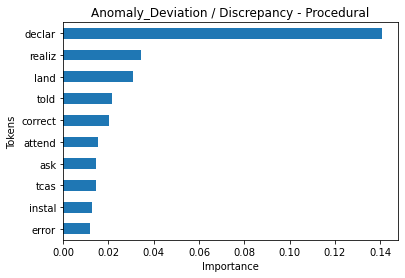

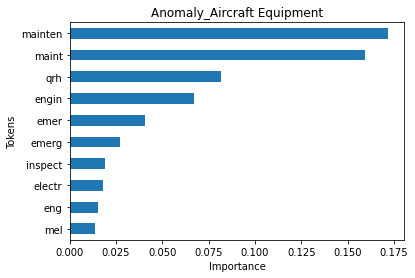

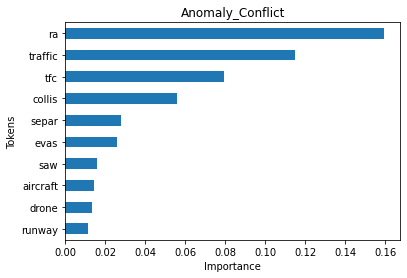

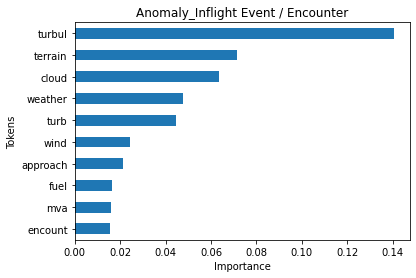

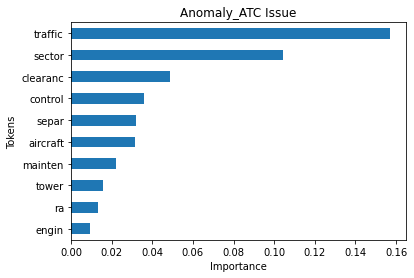

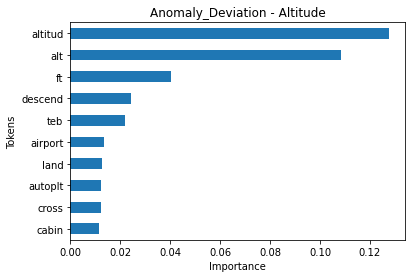

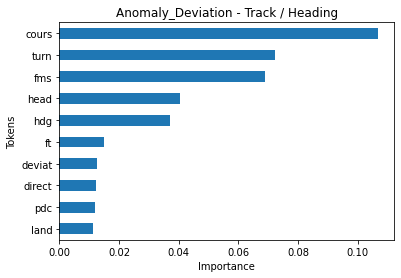

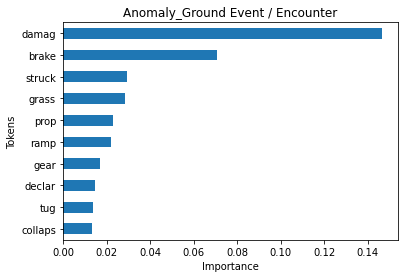

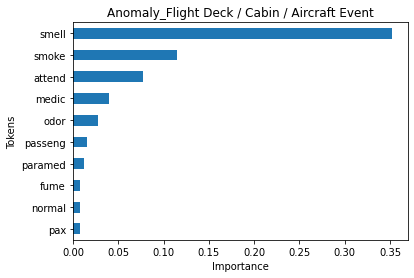

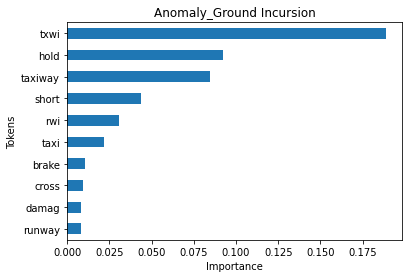

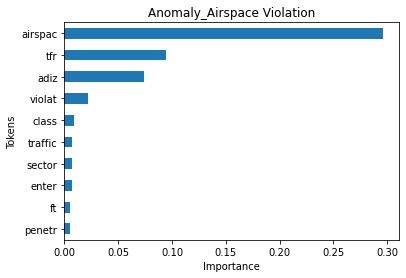

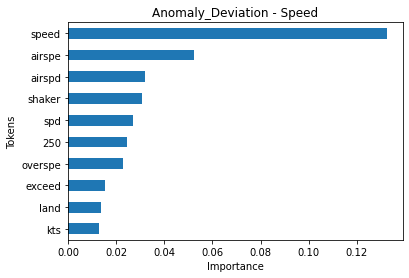

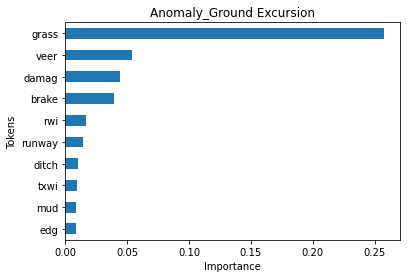

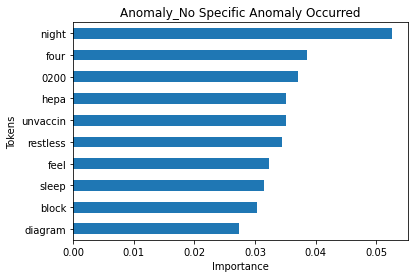

In [ ]:
# Plots the top 10 most important features for each Anomaly label
for Anomaly in target.columns:
  col_importance = 'Importance_' + Anomaly
  topfeatures = df_importances.sort_values(by = col_importance, ascending = True).tail(10)
  topfeatures.set_index('token').plot.barh(  y=[col_importance],legend=None) 
  plt.xlabel('Importance')
  plt.ylabel('Tokens')
  plt.title(Anomaly)

## For presentation

In [ ]:
target.columns

Index(['Anomaly_Deviation / Discrepancy - Procedural',
       'Anomaly_Aircraft Equipment', 'Anomaly_Conflict',
       'Anomaly_Inflight Event / Encounter', 'Anomaly_ATC Issue',
       'Anomaly_Deviation - Altitude', 'Anomaly_Deviation - Track / Heading',
       'Anomaly_Ground Event / Encounter',
       'Anomaly_Flight Deck / Cabin / Aircraft Event',
       'Anomaly_Ground Incursion', 'Anomaly_Airspace Violation',
       'Anomaly_Deviation - Speed', 'Anomaly_Ground Excursion',
       'Anomaly_No Specific Anomaly Occurred'],
      dtype='object')

<Figure size 288x144 with 0 Axes>

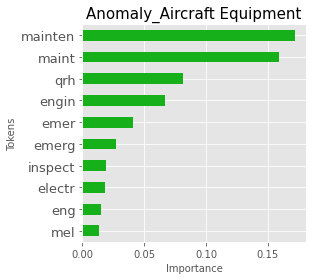

<Figure size 288x144 with 0 Axes>

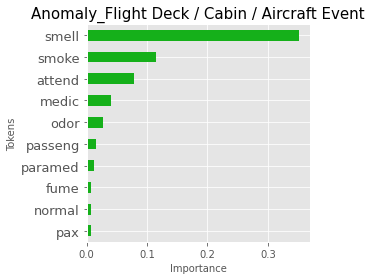

In [ ]:
# Plots the top 10 most important features for each Anomaly label
for Anomaly in [ 'Anomaly_Aircraft Equipment','Anomaly_Flight Deck / Cabin / Aircraft Event']:
  col_importance = 'Importance_' + Anomaly
  topfeatures = df_importances.sort_values(by = col_importance, ascending = True).tail(10)
  fig = plt.figure(figsize=(4,2))
  plt.style.use('ggplot')
  plt.rcParams['axes.titlesize'] = 15
  plt.rcParams['axes.labelsize'] = 10
  plt.rcParams['xtick.labelsize'] = 10
  plt.rcParams['ytick.labelsize'] = 13
  topfeatures.set_index('token').plot.barh(  y=[col_importance],color='#15B01A',legend=None,figsize=(4,4)) 
  plt.xlabel('Importance')
  plt.ylabel('Tokens')
  plt.title(Anomaly);

# INTERPRETABILITY ATTEMPT WITH SHAP

## Training a Decision Tree for 1 anomaly 

In [ ]:
# Anomaly to test
Anomaly='Anomaly_Deviation - Speed'
# Form of narratives : 'Narrative_Raw_Stemmed_str' or 'Narrative_PP_stemmed_str'
Narrative_form='Narrative_PP_stemmed_str'

In [ ]:
# We train a new DT, only for one anomaly , baseline-like, but with a reduced vocabulary of ~3800 tokens (unsupervised approach with min_df=100)
# The reason is that SHAP doesn't accept as input the sparse matrix (which is the output of the Countvectorizer) , and thus requires to get a dense matrix representation with todense().
#  which won't run (memory) with the whole original vocabulary of >50k tokens 


data = df[Narrative_form]
target = df[[Anomaly]]
vectorizer = CountVectorizer(token_pattern=r"\b[a-zA-Z][a-zA-Z]+\b",
                             min_df = 100) # reduced vocabulary, excluding numbers 

classifier=DecisionTreeClassifier(max_depth = 20)
# Train-test split  
X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                    test_size= 0.2, 
                                                    random_state = 12)

# apply the vectorizer 
X_train = vectorizer.fit_transform(X_train) 
X_test = vectorizer.transform(X_test) 
vocab = vectorizer.get_feature_names_out()
print("Vocabulary length:" , len(vocab))

# Instantiate variables
df_importances = pd.DataFrame(vocab).rename(columns={0: 'token'})
metrics_df_list = []

print('Prediction of anomaly :', Anomaly)

# Select the correct target data
y_train_Anomaly = y_train[Anomaly]
y_test_Anomaly = y_test[Anomaly]

# Train & predict
classifier.fit(X_train, y_train_Anomaly)
y_pred = classifier.predict(X_test)

Vocabulary length: 3683
Prediction of anomaly : Anomaly_Deviation - Speed


## Concatenate y_test, y_pred and useful data of original dataframe in df_y_test_pred

In [ ]:
cm=pd.crosstab(y_test[Anomaly],y_pred,rownames=['Classe réelle'],colnames=['Classe prédite'])
cm


Classe prédite,0,1
Classe réelle,,
0,18613,260
1,343,182


In [ ]:
Anomaly_Prediction=Anomaly+'_Prediction'
df_y_test_pred=pd.concat([y_test.reset_index() \
                       ,pd.DataFrame(y_pred).rename(columns={}).reset_index().rename(columns={'index':'index_test',0:Anomaly_Prediction}) \
                       ], axis=1) \
                       .set_index('ACN')

In [ ]:
df_y_test_pred.head()

,Anomaly_Deviation - Speed,index_test,Anomaly_Deviation - Speed_Prediction
ACN,,,
862838,0,0,0
1755023,0,1,0
1596818,0,2,0
1584414,0,3,0
1407775,0,4,0


In [ ]:
# Concat worked well - COnfusion matrix is respected
cm=pd.crosstab(df_y_test_pred[Anomaly],df_y_test_pred[Anomaly_Prediction],rownames=['Classe réelle'],colnames=['Classe prédite'])
cm


Classe prédite,0,1
Classe réelle,,
0,18613,260
1,343,182


In [ ]:
columns_to_keep=['Narrative',Narrative_form,'Anomaly']+Anomaly_RootLabels_columns
columns_to_keep.remove(Anomaly) # to avoid having 2 columns with our Anomaly in the following df
df_y_test_pred=df_y_test_pred.merge(right=df[columns_to_keep], on='ACN', how='left')


In [ ]:
df_y_test_pred['Narrative Nb Tokens']=df_y_test_pred[Narrative_form].apply(lambda x:len(x))

In [ ]:
print(df_y_test_pred.shape)
df_y_test_pred.head()

(19398, 20)


,Anomaly_Deviation - Speed,index_test,Anomaly_Deviation - Speed_Prediction,Narrative,Narrative_PP_stemmed_str,Anomaly,Anomaly_Deviation / Discrepancy - Procedural,Anomaly_Aircraft Equipment,Anomaly_Conflict,Anomaly_Inflight Event / Encounter,Anomaly_ATC Issue,Anomaly_Deviation - Altitude,Anomaly_Deviation - Track / Heading,Anomaly_Ground Event / Encounter,Anomaly_Flight Deck / Cabin / Aircraft Event,Anomaly_Ground Incursion,Anomaly_Airspace Violation,Anomaly_Ground Excursion,Anomaly_No Specific Anomaly Occurred,Narrative Nb Tokens
ACN,,,,,,,,,,,,,,,,,,,,
862838,0,0,0,The ATL/EUR charts include Europe Low Altitude...,atl / eur chart includ europ low altitud enrou...,Deviation / Discrepancy - Procedural Published...,1,0,0,0,0,0,0,0,0,0,0,0,0,474
1755023,0,1,0,While on approach for ILS 09R at SFB; Instruct...,approach il <runway> sfb instructor notic smal...,Conflict NMAC,0,0,1,0,0,0,0,0,0,0,0,0,0,673
1596818,0,2,0,Electrical system failure; suspected alternato...,electr system failur suspect altern altern bel...,Aircraft Equipment Problem Critical,0,1,0,0,0,0,0,0,0,0,0,0,0,492
1584414,0,3,0,During cruise flight approximately 50 to 60 mi...,cruis flight approxim 50 60 mile east fix offs...,Aircraft Equipment Problem Less Severe; Deviat...,1,1,0,0,0,0,1,0,0,0,0,0,0,615
1407775,0,4,0,We were in cruise at FL270 when we noticed the...,cruis feet notic oil pressur right engin fluct...,Aircraft Equipment Problem Critical,0,1,0,0,0,0,0,0,0,0,0,0,0,597


In [ ]:
print('True positives',len(df_y_test_pred[(df_y_test_pred[Anomaly]==1)&(df_y_test_pred[Anomaly_Prediction]==1)]) )
print('False positives',len(df_y_test_pred[(df_y_test_pred[Anomaly]==0)&(df_y_test_pred[Anomaly_Prediction]==1)]) )
print('False negatives',len(df_y_test_pred[(df_y_test_pred[Anomaly]==1)&(df_y_test_pred[Anomaly_Prediction]==0)]) )
print('True negatives',len(df_y_test_pred[(df_y_test_pred[Anomaly]==0)&(df_y_test_pred[Anomaly_Prediction]==0)]) )

True positives 182
False positives 260
False negatives 343
True negatives 18613


## Plotting the importance of tokens

In [ ]:
#########  FEATURE IMPORTANCE ################
# write features and their importance into a dict
feats={}
for feature,importance in zip(vocab, classifier.feature_importances_):
  feats[feature] = importance

# Create a DataFrame from the dict. Each anomaly label gets a new column
col_importance = 'Importance_' + Anomaly
importance = pd.DataFrame.from_dict(feats, orient = 'index').reset_index().rename(columns = {'index': 'token', 0: col_importance})
df_importances = df_importances.merge(importance, on = 'token', how = 'left')


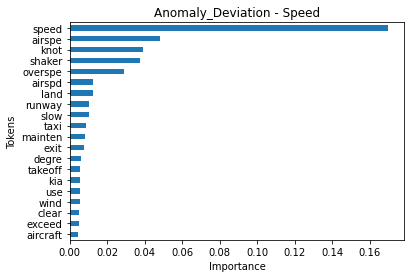

In [ ]:
# Plots the top n important features of the DT
n=20

col_importance = 'Importance_' + Anomaly
topfeatures = df_importances.sort_values(by = col_importance, ascending = True).tail(n)
topfeatures.set_index('token').plot.barh(  y=[col_importance],legend=None) 
plt.xlabel('Importance')
plt.ylabel('Tokens')
plt.title(Anomaly);

## Implementing SHAP on test set for the Decision tree

In [ ]:
#SHAP doesn't accept as input the sparse matrix (which is the output of the Countvectorizer) , and thus requires to get a dense matrix representation with todense().
X_test_TD=X_test.todense() 
X_test_TD=np.array(X_test_TD)
explainer = shap.TreeExplainer(classifier,X_test_TD)
shap_values = explainer.shap_values(X_test_TD)

 95%|=================== | 36667/38796 [00:17<00:00]       

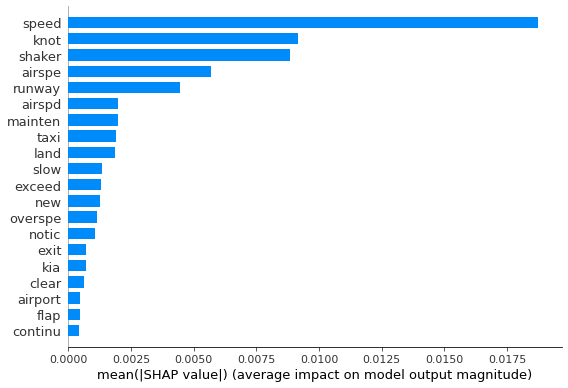

In [ ]:
# SHAP VALUES 

modality=1
shap.summary_plot(shap_values[modality], vocab, plot_type="bar",plot_size=0.2)

## Highlighting local interpretability with SHAP

In [ ]:
# Frequence (in%) of Anomaly in terst data set
np.mean(df_y_test_pred[Anomaly])*100

2.7064645839777297

### Example for a short True positive narrative
(<200 tokens)

In [ ]:
example_index=random.choice(df_y_test_pred[(df_y_test_pred[Anomaly]==1)&(df_y_test_pred[Anomaly_Prediction]==1)&(df_y_test_pred['Narrative Nb Tokens']<=200)].index)
example_index

638506

In [ ]:
df_y_test_pred.loc[example_index,'Narrative']

'DEV FROM PROC/REG FARS. DECLARED A MEDICAL EMER AT FL310; EXCEEDED 250 KT RESTR BELOW 10000 FT TO GET THE PAX TO THE HOSPITAL ASAP. LANDED AT ZZZ ABOUT 10 MINS AFTER MEDICAL EMER DECLARED.'

In [ ]:
df_y_test_pred.loc[example_index,Narrative_form]

'deviat procedur / regul far declar medic emerg feet exceed 250 knot restrict 10000 feet get passeng hospit asap land zzz 10 minut medic emerg declar'

In [ ]:
df_y_test_pred.loc[example_index,Anomaly_RootLabels_columns]

Anomaly_Deviation / Discrepancy - Procedural    1
Anomaly_Aircraft Equipment                      0
Anomaly_Conflict                                0
Anomaly_Inflight Event / Encounter              0
Anomaly_ATC Issue                               0
Anomaly_Deviation - Altitude                    0
Anomaly_Deviation - Track / Heading             0
Anomaly_Ground Event / Encounter                0
Anomaly_Flight Deck / Cabin / Aircraft Event    1
Anomaly_Ground Incursion                        0
Anomaly_Airspace Violation                      0
Anomaly_Deviation - Speed                       1
Anomaly_Ground Excursion                        0
Anomaly_No Specific Anomaly Occurred            0
Name: 638506, dtype: object

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[modality], shap_values[modality][df_y_test_pred.loc[example_index,'index_test'],:], vocab)

### Example for a short False positive narrative

In [ ]:
example_index=random.choice(df_y_test_pred[(df_y_test_pred[Anomaly]==0)&(df_y_test_pred[Anomaly_Prediction]==1)&(df_y_test_pred['Narrative Nb Tokens']<=200)].index)
example_index

1315808

In [ ]:
df_y_test_pred.loc[example_index,'Narrative']

'During climb out of Dubai around 4000 ft with clean configuration and foot +15 we had momentary stick shaker due to wake turbulence from preceding B777.'

In [ ]:
df_y_test_pred.loc[example_index,Narrative_form]

'climb dubai around 4000 feet clean configur foot + 15 momentari stick shaker due wake turbul preced b777'

In [ ]:
df_y_test_pred.loc[example_index,Anomaly_RootLabels_columns]

Anomaly_Deviation / Discrepancy - Procedural    0
Anomaly_Aircraft Equipment                      0
Anomaly_Conflict                                0
Anomaly_Inflight Event / Encounter              1
Anomaly_ATC Issue                               0
Anomaly_Deviation - Altitude                    0
Anomaly_Deviation - Track / Heading             0
Anomaly_Ground Event / Encounter                0
Anomaly_Flight Deck / Cabin / Aircraft Event    0
Anomaly_Ground Incursion                        0
Anomaly_Airspace Violation                      0
Anomaly_Deviation - Speed                       0
Anomaly_Ground Excursion                        0
Anomaly_No Specific Anomaly Occurred            0
Name: 1315808, dtype: object

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[modality], shap_values[modality][df_y_test_pred.loc[example_index,'index_test'],:], vocab)

### Example for a short True negative  narrative

In [ ]:
example_index=random.choice(df_y_test_pred[(df_y_test_pred[Anomaly]==0)&(df_y_test_pred[Anomaly_Prediction]==0)&(df_y_test_pred['Narrative Nb Tokens']<=200)].index)
example_index

665735

In [ ]:
df_y_test_pred.loc[example_index,'Narrative']

'THROUGH BOLT ON #1 MAIN LNDG GEAR TIRE BROKEN.'

In [ ]:
df_y_test_pred.loc[example_index,Narrative_form]

'bolt # 1 main land gear tire broken'

In [ ]:
df_y_test_pred.loc[example_index,Anomaly_RootLabels_columns]

Anomaly_Deviation / Discrepancy - Procedural    1
Anomaly_Aircraft Equipment                      1
Anomaly_Conflict                                0
Anomaly_Inflight Event / Encounter              0
Anomaly_ATC Issue                               0
Anomaly_Deviation - Altitude                    0
Anomaly_Deviation - Track / Heading             0
Anomaly_Ground Event / Encounter                0
Anomaly_Flight Deck / Cabin / Aircraft Event    0
Anomaly_Ground Incursion                        0
Anomaly_Airspace Violation                      0
Anomaly_Deviation - Speed                       0
Anomaly_Ground Excursion                        0
Anomaly_No Specific Anomaly Occurred            0
Name: 665735, dtype: object

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[modality], shap_values[modality][df_y_test_pred.loc[example_index,'index_test'],:], vocab)

### Example for a short False negative narrative

In [ ]:
example_index=random.choice(df_y_test_pred[(df_y_test_pred[Anomaly]==1)&(df_y_test_pred[Anomaly_Prediction]==0)&(df_y_test_pred['Narrative Nb Tokens']<=200)].index)
example_index

1132662

In [ ]:
df_y_test_pred.loc[example_index,'Narrative']

'Minimum spacing takeoff behind company aircraft; they were assigned a heading and we were assigned the BBKNG RNAV. Encountered wake turbulence and airspeed fluctuated above and below 250 KTS while below 10;000 FT. Took immediate corrective action; ATC turned us to a heading of 180.'

In [ ]:
df_y_test_pred.loc[example_index,Narrative_form]

'minimum space takeoff behind compani aircraft assign head assign bbkng rnav encount wake turbul airspe fluctuat 250 knot 10 000 feet took immedi correct action atc turn us head 180'

In [ ]:
df_y_test_pred.loc[example_index,Anomaly_RootLabels_columns]

Anomaly_Deviation / Discrepancy - Procedural    0
Anomaly_Aircraft Equipment                      0
Anomaly_Conflict                                0
Anomaly_Inflight Event / Encounter              1
Anomaly_ATC Issue                               1
Anomaly_Deviation - Altitude                    0
Anomaly_Deviation - Track / Heading             0
Anomaly_Ground Event / Encounter                0
Anomaly_Flight Deck / Cabin / Aircraft Event    0
Anomaly_Ground Incursion                        0
Anomaly_Airspace Violation                      0
Anomaly_Deviation - Speed                       1
Anomaly_Ground Excursion                        0
Anomaly_No Specific Anomaly Occurred            0
Name: 1132662, dtype: object

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[modality], shap_values[modality][df_y_test_pred.loc[example_index,'index_test'],:], vocab)